this script is for visualizing the results from the case study

In [49]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [50]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty, game_is_superadditive
from src.nucleolus import get_nucleolus
from src.least_core_nucleolus import get_least_core_nucleolus

In [51]:
def make_game_superadditive(v: dict, players: list) -> dict:
    """
    make game superadditive by adjusting values of coalitions

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    """
    v_superadd = v.copy()
    for S in powerset(players, exclude_empty=True):
        T = frozenset(players) - S
        union = S.union(T)
        if v_superadd[union] < v_superadd[S] + v_superadd[T]:
            v_superadd[union] = v_superadd[S] + v_superadd[T]
    return v_superadd

In [52]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_24660\536717058.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [53]:
services = ['FFR-FCR']  # list of services to visualize
dvpps_infos = {}  # dictionary to hold dvpp info dataframes
main_path = 'pics/v_case_0604/'
df_expected = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_expected.columns = [tuple(c for c in col if c!='nan') for col in df_expected.columns.values]
df_realized = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
for service in services:
    dvpps_infos[service] = pd.read_csv(f'{main_path}dvpp_info_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

# Reward Split

## Pure-Nucleolus Reward Split

In [54]:
# get reward split of devices
players = [c[0] for c in df_expected.columns if len(c)==1]
idxes = pd.MultiIndex.from_product((df_expected.index.get_level_values(1), ['E-Value', 'E-Nucleolus', 'R-Value', 'R-Nucleolus']))
df_reward_split = pd.DataFrame(0.0, index=idxes, columns=players)
superadditivity_counter = 0
convexity_counter = 0
core_non_empty_counter = 0
for idx, row in df_expected.iterrows():
    # 1. Expected game convert to dictionary
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    # v = make_game_superadditive(v, players)  # ensure superadditivity
    if game_is_superadditive(v, players):
        superadditivity_counter += 1
        nucleolus = get_nucleolus(v, players)
    else:
        print(f"for time {idx[0]}, expected game is not superadditive.")
        print(v)
        nucleolus = get_least_core_nucleolus(v, players)
    if is_convex_game(v, players):
        convexity_counter += 1
    if core_nonempty(v, players):
        core_non_empty_counter += 1
    df_reward_split.loc[(idx[1], 'E-Nucleolus'), list(k for k in nucleolus.keys())] = list(nucleolus.values())
    df_reward_split.loc[(idx[1], 'E-Value'), list(p for p in players)] = [v[frozenset({p})] for p in players]
    # 2. Realized game convert to dictionary
    v_realized = {frozenset(k): val for k, val in df_realized.loc[idx].items()}
    v_realized[frozenset()] = 0.0  # ensure empty set
    nucleolus_realized = get_least_core_nucleolus(v_realized, players)
    df_reward_split.loc[(idx[1], 'R-Nucleolus'), list(k for k in nucleolus_realized.keys())] = list(nucleolus_realized.values())
    df_reward_split.loc[(idx[1], 'R-Value'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]

for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 1.4768, frozenset({'Wind'}): 0.05355, frozenset({'BESS'}): 0.0, frozenset({'PV', 'Wind'}): 1.40456, frozenset({'PV', 'BESS'}): 3.71608, frozenset({'BESS', 'Wind'}): 0.16098, frozenset({'PV', 'BESS', 'Wind'}): 3.71608, frozenset(): 0.0}


In [55]:
print(f"Out of {len(df_expected)} games, {superadditivity_counter} superadditive, {convexity_counter} convex and {core_non_empty_counter} non-empty core.") 

Out of 25 games, 24 superadditive, 15 convex and 24 non-empty core.


<Axes: >

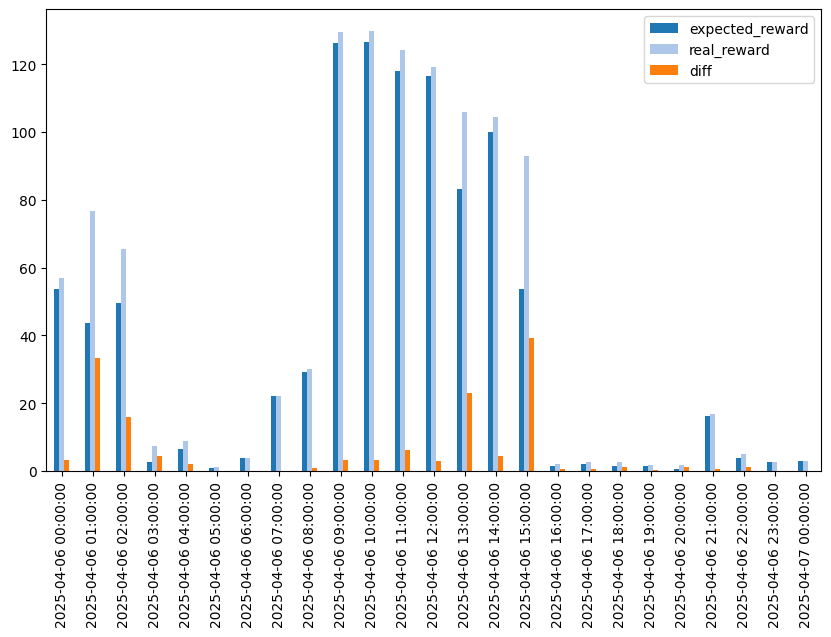

In [56]:
df_exp_real = dvpps_infos[service].groupby(level=0)[['expected_reward', 'real_reward']].mean()
df_exp_real['diff'] = df_exp_real['real_reward'] - df_exp_real['expected_reward']
df_exp_real.plot.bar(figsize=(10,6))

## New: combined Shapley - Nucleolus Reward Split

In [57]:
import itertools

class CooperativeGameItertools:
    def __init__(self, players, characteristic_function):
        self.players = sorted(players)
        # We keep the original v (likely with frozenset keys) for value lookups
        self.v_original = characteristic_function
        
        # We create a "clean" version with tuple keys for the internal structure algorithm
        self.v_clean = {}
        for k, val in characteristic_function.items():
            # Handle both frozenset and tuple inputs
            key_tuple = tuple(sorted(list(k)))
            self.v_clean[key_tuple] = val
        self.v_clean[()] = 0
        
        self.memo = {}

    def _get_powerset(self, iterable):
        s = list(iterable)
        return itertools.chain.from_iterable(
            itertools.combinations(s, r) for r in range(len(s) + 1)
        )

    def get_optimal_coalition_structure(self):
        """Returns (max_value, structure_list) e.g., (10, [('A', 'B'), ('C',)])"""
        self.memo = {}
        return self._solve_recursive(tuple(self.players))

    def _solve_recursive(self, current_players):
        if not current_players:
            return 0, []
        if current_players in self.memo:
            return self.memo[current_players]

        best_value = -1
        best_structure = []
        
        first_player = current_players[0]
        rest_of_players = current_players[1:]

        for partner_subset in self._get_powerset(rest_of_players):
            current_coalition = tuple(sorted((first_player,) + partner_subset))
            current_coalition_val = self.v_clean.get(current_coalition, 0)

            remaining_set = set(current_players) - set(current_coalition)
            remaining_tuple = tuple(sorted(remaining_set))

            rem_val, rem_structure = self._solve_recursive(remaining_tuple)
            total_val = current_coalition_val + rem_val

            if total_val > best_value:
                best_value = total_val
                best_structure = [current_coalition] + rem_structure

        self.memo[current_players] = (best_value, best_structure)
        return best_value, best_structure

    def get_player_values(self, structure, game_v_dict, 
                          check_convex_func, check_core_func, check_super_func, 
                          calc_shapley_func, calc_nucleolus_func):
        """
        Calculates values for players based on the provided coalition structure.
        It creates a sub-game for each coalition and applies the relevant allocation method.
        
        Parameters:
        - structure: List of tuples, e.g. [('A','B'), ('C',)]
        - game_v_dict: The characteristic function (v or v_realized) to use for calculation
        - check_*_func: Your external boolean check functions
        - calc_*_func: Your external allocation functions
        """
        final_payouts = {}

        for coalition_tuple in structure:
            sub_players = list(coalition_tuple)
            
            # 1. Create the Sub-Game Characteristic Function (Restricted Game)
            # We filter the main dict for keys that are subsets of the current coalition
            sub_v = {}
            sub_players_set = set(sub_players)
            
            # We must iterate the powerset of the sub_players to build sub_v
            # This ensures we pass a complete game dictionary to the helper functions
            for r in range(1, len(sub_players) + 1):
                for combo in itertools.combinations(sub_players, r):
                    # Construct key as frozenset to match your helper functions' expectation
                    key_fs = frozenset(combo)
                    # Look up value in the passed dictionary (Expected or Realized)
                    val = game_v_dict.get(key_fs, 0.0)
                    sub_v[key_fs] = val
            sub_v[frozenset()] = 0.0

            # 2. Determine Allocation Method for this Sub-Coalition
            if check_convex_func(sub_v, sub_players):
                # Case A: Convex Sub-Game
                payouts = calc_shapley_func(sub_v, sub_players)
            elif check_core_func(sub_v, sub_players) or check_super_func(sub_v, sub_players):
                # Case B: Core/Superadditive Sub-Game
                payouts = calc_nucleolus_func(sub_v, sub_players)
            else:
                # Case C: Unstable Sub-Game fallback
                # If a sub-coalition forms but is internally unstable, Nucleolus (Least Core) 
                # is usually the safest scientific choice to minimize dissatisfaction.
                payouts = calc_nucleolus_func(sub_v, sub_players)

            final_payouts.update(payouts)

        return final_payouts

In [84]:
v = {frozenset({'A'}): 3,
     frozenset({'B'}): 2,
     frozenset({'C'}): 7,
     frozenset({'A','B'}): 7.9,
    frozenset({'A','C'}): 12,
    frozenset({'B','C'}): 1,
    frozenset({'A','B','C'}): 15,
    frozenset(): 0.0}
players = ['A','B','C']
print(f'Is convex game: {is_convex_game(v, players)}')
print(f'Is superadditive game: {game_is_superadditive(v, players)}')
print(f'Is core non-empty: {core_nonempty(v, players, return_allocation=True)}')
game_iter = CooperativeGameItertools(players, v)
max_value, structure = game_iter.get_optimal_coalition_structure()
print(f'Optimal coalition structure: {structure} with value {max_value}')

Is convex game: False
Is superadditive game: False
Is core non-empty: (True, array([6., 2., 7.]))
Optimal coalition structure: [('A', 'B', 'C')] with value 15


In [ ]:
# get reward split of devices
players = [c[0] for c in df_expected.columns if len(c)==1]
idxes = pd.MultiIndex.from_product((df_expected.index.get_level_values(1), ['E-Alone', 'E-Reward', 'R-Alone', 'R-Reward', 'Method']))
df_reward_split = pd.DataFrame(0.0, index=idxes, columns=players)
superadditivity_counter = 0
convexity_counter = 0
core_non_empty_counter = 0
sub_coalition_counter = 0
for idx, row in df_expected.iterrows():
    # 1. Expected game convert to dictionary
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    # v = make_game_superadditive(v, players)  # ensure superadditivity
    v_realized = {frozenset(k): val for k, val in df_realized.loc[idx].items()}
    v_realized[frozenset()] = 0.0  # ensure empty set
    if is_convex_game(v, players):
        convexity_counter += 1
        # apply Shapley value
        shapley = get_shapley_value(v, players)
        df_reward_split.loc[(idx[1], 'E-Reward'), list(k for k in shapley.keys())] = list(shapley.values())
        df_reward_split.loc[(idx[1], 'E-Alone'), list(p for p in players)] = [v[frozenset({p})] for p in players]
        # 2. compute realized game
        shapley_realized = get_shapley_value(v_realized, players)
        df_reward_split.loc[(idx[1], 'R-Reward'), list(k for k in shapley_realized.keys())] = list(shapley_realized.values())
        df_reward_split.loc[(idx[1], 'R-Alone'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]
        df_reward_split.loc[(idx[1], 'Method'), :] = 'Shapley'
    elif core_nonempty(v, players) or game_is_superadditive(v, players):
        if core_nonempty(v, players): core_non_empty_counter += 1
        if game_is_superadditive(v, players):  superadditivity_counter += 1
        # apply Nucleolus value
        nucleolus = get_nucleolus(v, players)
        df_reward_split.loc[(idx[1], 'E-Reward'), list(k for k in nucleolus.keys())] = list(nucleolus.values())
        df_reward_split.loc[(idx[1], 'E-Alone'), list(p for p in players)] = [v[frozenset({p})] for p in players]
        # 2. compute realized game
        nucleolus_realized = get_least_core_nucleolus(v_realized, players)
        df_reward_split.loc[(idx[1], 'R-Reward'), list(k for k in nucleolus_realized.keys())] = list(nucleolus_realized.values())
        df_reward_split.loc[(idx[1], 'R-Alone'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]
        df_reward_split.loc[(idx[1], 'Method'), :] = 'Nucleolus'
    else:
        # game is neither convex nor has non-empty core nor superadditive
        sub_coalition_counter += 1
        
        # 1. Initialize Game Analysis Class
        game = CooperativeGameItertools(players, v)
        
        # 2. Determine WHO breaks away (Structure based on Expected Value v)
        value_struct, structure = game.get_optimal_coalition_structure()
        
        df_reward_split.loc[(idx[1], 'Method'), :] = 'Sub-Coalitions'
        
        # 3. Calculate EXPECTED Rewards (Applying logic to v)
        # We pass your external functions into the method
        expected_payouts = game.get_player_values(
            structure=structure,
            game_v_dict=v,
            check_convex_func=is_convex_game,
            check_core_func=core_nonempty,
            check_super_func=game_is_superadditive,
            calc_shapley_func=get_shapley_value,
            calc_nucleolus_func=get_nucleolus
        )
        
        df_reward_split.loc[(idx[1], 'E-Reward'), list(expected_payouts.keys())] = list(expected_payouts.values())
        df_reward_split.loc[(idx[1], 'E-Alone'), list(p for p in players)] = [v[frozenset({p})] for p in players]

        # 4. Calculate REALIZED Rewards (Applying SAME structure to v_realized)
        # Note: We use get_least_core_nucleolus for the realized fallback, 
        # but we use the structure determined by expectation.
        realized_payouts = game.get_player_values(
            structure=structure,
            game_v_dict=v_realized,
            check_convex_func=is_convex_game,
            check_core_func=core_nonempty,
            check_super_func=game_is_superadditive,
            calc_shapley_func=get_shapley_value,
            calc_nucleolus_func=get_least_core_nucleolus # Use your specific realized nucleolus function here
        )

        df_reward_split.loc[(idx[1], 'R-Reward'), list(realized_payouts.keys())] = list(realized_payouts.values())
        df_reward_split.loc[(idx[1], 'R-Alone'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]

        print(f"Time {idx[1]}: Grand Coalition Unstable. Forming: {structure}")

Time 6: Grand Coalition Unstable. Forming: [('BESS', 'PV'), ('Wind',)]


C:\Users\pasca\AppData\Local\Temp\ipykernel_24660\3079817364.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Shapley' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_reward_split.loc[(idx[1], 'Method'), :] = 'Shapley'
C:\Users\pasca\AppData\Local\Temp\ipykernel_24660\3079817364.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Shapley' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_reward_split.loc[(idx[1], 'Method'), :] = 'Shapley'
C:\Users\pasca\AppData\Local\Temp\ipykernel_24660\3079817364.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Shapley' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
 

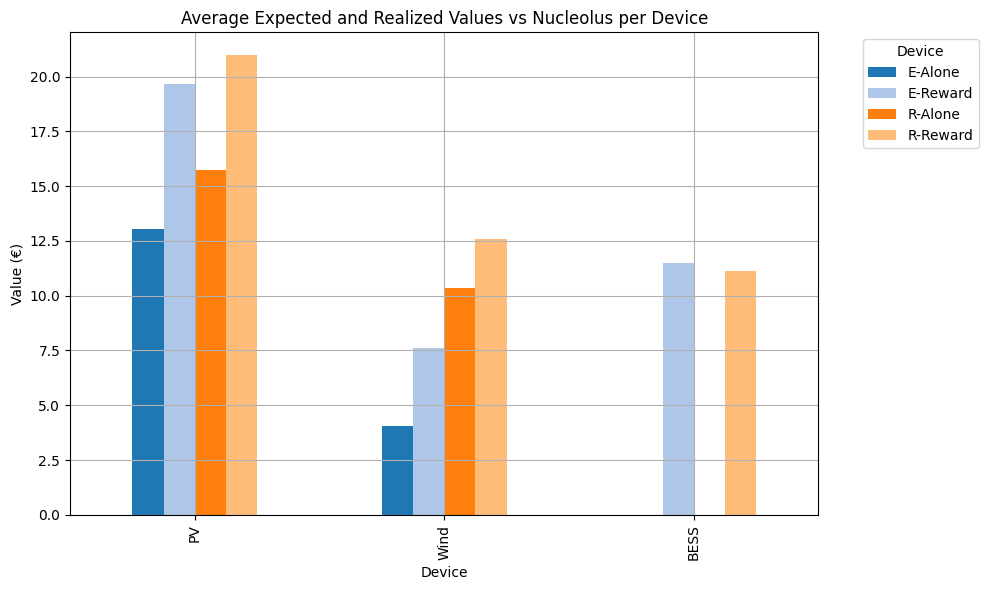

In [ ]:
# plot bar chart of average value vs nucleolus for each device
fig, ax = plt.subplots(figsize=(10, 6))

# remove 'Method' rows for plotting
df_plot = df_reward_split[df_reward_split.index.get_level_values(1) != 'Method']

df_reward_split_mean = df_plot.groupby(level=1).mean()
df_reward_split_std = df_plot.groupby(level=1).std()
df_reward_split_mean = df_reward_split_mean.transpose()
df_reward_split_std = df_reward_split_std.transpose()
df_reward_split_mean.plot.bar(ax=ax)
ax.set_title('Average Expected and Realized Values vs Nucleolus per Device')
ax.set_ylabel('Value (€)')
ax.set_xlabel('Device')
ax.legend(title='Device', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

<Axes: >

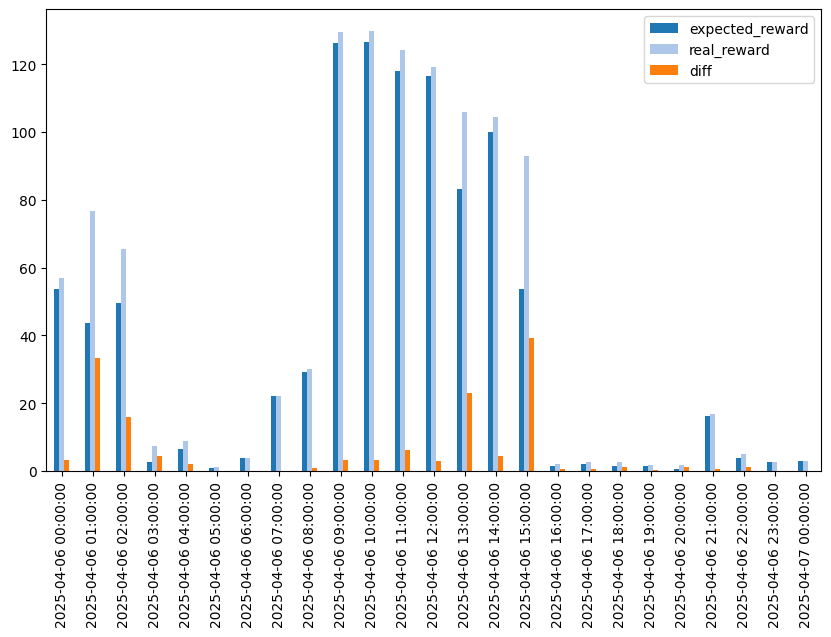

In [ ]:
df_exp_real = dvpps_infos[service].groupby(level=0)[['expected_reward', 'real_reward']].mean()
df_exp_real['diff'] = df_exp_real['real_reward'] - df_exp_real['expected_reward']
df_exp_real.plot.bar(figsize=(10,6))